In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sklearn as skl
import tensorflow as tf
import yfinance as yf
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from pathlib import Path
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import json
import os
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
import seaborn as sb
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [2]:
client = MongoClient("mongodb://localhost:27017/Group_Project")
db=client.Group_Project

In [3]:
SoyOil=pd.DataFrame(list(db.SoyOil.find())).drop("_id",axis=1)
SoyOil

SoyOil Close  Price_Change Buy/Hold  Corn P_Close  Wheat P_Close  \
0        57.750000      0.627678      Buy        407.50         597.50   
1        57.020000      0.613469      Buy        406.75         602.00   
2        56.369999      0.589230      Buy        409.25         609.25   
3        53.869999      0.566444      Buy        405.25         606.00   
4        53.520000      0.584370      Buy        401.00         608.00   
...            ...           ...      ...           ...            ...   
3956     22.040001      0.095427      Buy           NaN            NaN   
3957     22.260000      0.098175      Buy           NaN            NaN   
3958     22.020000      0.096614      Buy           NaN            NaN   
3959     22.160000      0.111334      Buy           NaN            NaN   
3960     21.980000      0.106747      Buy           NaN            NaN   

      Cotton P_Close  Crude P_Close  USDBRL P_Close  EURUSD P_Close  \
0          70.000000      40.290001          5.3272        1.186366   
1          68.620003      37.139999          5.4149        1.185944   
2          70.070000      38.790001          5.4570        1.184525   
3          70.230003      39.150002          5.4567        1.180339   
4          70.239998      37.660000          5.3900        1.178030   
...              ...            ...             ...             ...   
3956             NaN            NaN             NaN             NaN   
3957             NaN            NaN             NaN             NaN   
3958             NaN            NaN             NaN             NaN   
3959             NaN            NaN             NaN             NaN   
3960             NaN            NaN             NaN             NaN   

      IR P_Close  Soybeans P_Close  Sugar P_Close  
0          0.958           1105.00          14.88  
1          0.820           1098.50          14.91  
2          0.776           1101.75          14.48  
3          0.768           1079.00          14.65  
4          0.882           1059.00          14.72  
...          ...               ...            ...  
3956         NaN               NaN            NaN  
3957         NaN               NaN            NaN  
3958         NaN               NaN            NaN  
3959         NaN               NaN            NaN  
3960         NaN               NaN            NaN  

[3961 rows x 12 columns]

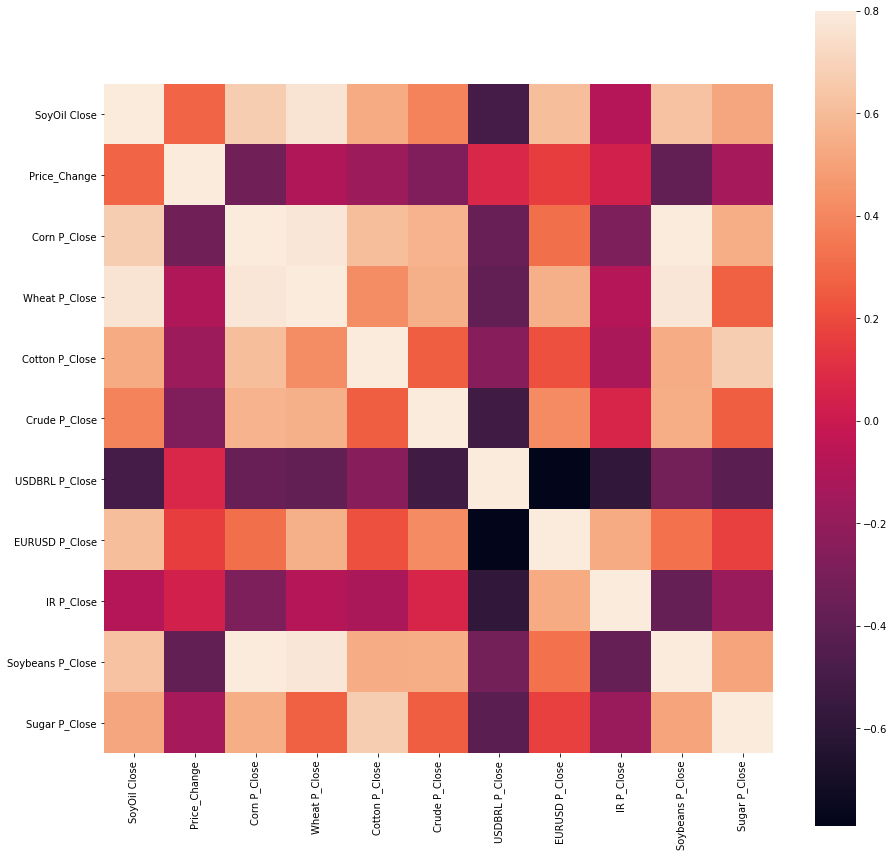

In [4]:
C_mat = SoyOil.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax=.8, square =True)
plt.show()

In [5]:
App_cat = SoyOil.dtypes[SoyOil.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(SoyOil[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)
encode_df.head()

Buy/Hold_Buy  Buy/Hold_Hold
0           1.0            0.0
1           1.0            0.0
2           1.0            0.0
3           1.0            0.0
4           1.0            0.0

In [6]:
SoyOil = SoyOil.merge(encode_df,left_index=True, right_index=True)
SoyOil = SoyOil.drop(App_cat,1)
SoyOil.head()

SoyOil Close  Price_Change  Corn P_Close  Wheat P_Close  Cotton P_Close  \
0     57.750000      0.627678        407.50         597.50       70.000000   
1     57.020000      0.613469        406.75         602.00       68.620003   
2     56.369999      0.589230        409.25         609.25       70.070000   
3     53.869999      0.566444        405.25         606.00       70.230003   
4     53.520000      0.584370        401.00         608.00       70.239998   

   Crude P_Close  USDBRL P_Close  EURUSD P_Close  IR P_Close  \
0      40.290001          5.3272        1.186366       0.958   
1      37.139999          5.4149        1.185944       0.820   
2      38.790001          5.4570        1.184525       0.776   
3      39.150002          5.4567        1.180339       0.768   
4      37.660000          5.3900        1.178030       0.882   

   Soybeans P_Close  Sugar P_Close  Buy/Hold_Buy  Buy/Hold_Hold  
0           1105.00          14.88           1.0            0.0  
1           1098.50          14.91           1.0            0.0  
2           1101.75          14.48           1.0            0.0  
3           1079.00          14.65           1.0            0.0  
4           1059.00          14.72           1.0            0.0

In [8]:
# Split our preprocessed data into our features and target arrays
ySO_ = SoyOil["Buy/Hold_Hold"].values
XSO_ = SoyOil.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XSO_train, XSO_test, ySO_train, ySO_test = train_test_split(XSO_, ySO_, random_state=78)

In [9]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XSO_scaler = scaler.fit(XSO_train)
XSO_scaler
#Scale the data
XSO_train_scaled = XSO_scaler.transform(XSO_train)
XSO_test_scaled = XSO_scaler.transform(XSO_test)

In [10]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(XSO_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30




nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))



# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 3,501
Trainable params: 3,501
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [13]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1000)

In [14]:
# Train the model
fit_model = nn.fit(XSO_train_scaled,ySO_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 685us/step - loss: nan - accuracy: 0.6493
Epoch 2/100
93/93 [==============================] - 0s 644us/step - loss: nan - accuracy: 0.6985
Epoch 3/100
93/93 [==============================] - 0s 649us/step - loss: nan - accuracy: 0.7012
Epoch 4/100
93/93 [==============================] - 0s 650us/step - loss: nan - accuracy: 0.7047
Epoch 5/100
93/93 [==============================] - 0s 660us/step - loss: nan - accuracy: 0.6967
Epoch 6/100
93/93 [==============================] - 0s 608us/step - loss: nan - accuracy: 0.7152
Epoch 7/100
93/93 [==============================] - 0s 617us/step - loss: nan - accuracy: 0.6988
Epoch 8/100
93/93 [==============================] - 0s 711us/step - loss: nan - accuracy: 0.6802
Epoch 9/100
93/93 [==============================] - 0s 660us/step - loss: nan - accuracy: 0.6858
Epoch 10/100
93/93 [==============================] - 0s 604us/step - loss: nan - accuracy: 0.6814
Epoch 11/100
 1/93 

93/93 [==============================] - 0s 609us/step - loss: nan - accuracy: 0.6880
Epoch 76/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.5938
Epoch 00076: saving model to checkpoints\weights.76.hdf5
93/93 [==============================] - 0s 761us/step - loss: nan - accuracy: 0.6822
Epoch 77/100
93/93 [==============================] - 0s 618us/step - loss: nan - accuracy: 0.6957
Epoch 78/100
93/93 [==============================] - 0s 621us/step - loss: nan - accuracy: 0.6995
Epoch 79/100
93/93 [==============================] - 0s 580us/step - loss: nan - accuracy: 0.6959
Epoch 80/100
93/93 [==============================] - 0s 645us/step - loss: nan - accuracy: 0.6942
Epoch 81/100
93/93 [==============================] - 0s 657us/step - loss: nan - accuracy: 0.6889
Epoch 82/100
93/93 [==============================] - 0s 579us/step - loss: nan - accuracy: 0.6879
Epoch 83/100
93/93 [==============================] - 0s 584us/step - loss: nan - ac

In [16]:
# Evaluate the model using the test data
SO_loss, SO_accuracy = nn.evaluate(XSO_test_scaled,ySO_test,verbose=2)
print(f"SoyOil Model Accuracy: {SO_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.7064
SoyOil Model Accuracy: 0.7063572406768799


In [17]:
Sugar=pd.DataFrame(list(db.Sugar.find())).drop("_id",axis=1)
App_cat = Sugar.dtypes[Sugar.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Sugar[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)


Sugar = Sugar.merge(encode_df,left_index=True, right_index=True)
Sugar = Sugar.drop(App_cat,1)



In [18]:
# Split our preprocessed data into our features and target arrays
yS_ = Sugar["Buy/Hold_Hold"].values
XS_ = Sugar.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XS_train, XS_test, yS_train, yS_test = train_test_split(XS_, yS_, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XS_scaler = scaler.fit(XS_train)
XS_scaler
#Scale the data
XS_train_scaled = XS_scaler.transform(XS_train)
XS_test_scaled = XS_scaler.transform(XS_test)

# Train the model
fit_model = nn.fit(XS_train_scaled,yS_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 634us/step - loss: nan - accuracy: 0.5717
Epoch 2/100
93/93 [==============================] - 0s 592us/step - loss: nan - accuracy: 0.5717
Epoch 3/100
93/93 [==============================] - 0s 598us/step - loss: nan - accuracy: 0.5717
Epoch 4/100
93/93 [==============================] - 0s 588us/step - loss: nan - accuracy: 0.5717
Epoch 5/100
93/93 [==============================] - 0s 590us/step - loss: nan - accuracy: 0.5717
Epoch 6/100
93/93 [==============================] - 0s 573us/step - loss: nan - accuracy: 0.5717
Epoch 7/100
93/93 [==============================] - 0s 574us/step - loss: nan - accuracy: 0.5717
Epoch 8/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6562
Epoch 00008: saving model to checkpoints\weights.08.hdf5
93/93 [==============================] - 0s 749us/step - loss: nan - accuracy: 0.5717
Epoch 9/100
93/93 [==============================] - 0s 667us/step - loss: nan 

93/93 [==============================] - 0s 712us/step - loss: nan - accuracy: 0.5717
Epoch 74/100
93/93 [==============================] - 0s 660us/step - loss: nan - accuracy: 0.5717
Epoch 75/100
93/93 [==============================] - 0s 561us/step - loss: nan - accuracy: 0.5717
Epoch 76/100
93/93 [==============================] - 0s 576us/step - loss: nan - accuracy: 0.5717
Epoch 77/100
93/93 [==============================] - 0s 568us/step - loss: nan - accuracy: 0.5717
Epoch 78/100
93/93 [==============================] - 0s 520us/step - loss: nan - accuracy: 0.5717
Epoch 79/100
93/93 [==============================] - 0s 588us/step - loss: nan - accuracy: 0.5717
Epoch 80/100
93/93 [==============================] - 0s 596us/step - loss: nan - accuracy: 0.5717
Epoch 81/100
93/93 [==============================] - 0s 542us/step - loss: nan - accuracy: 0.5717
Epoch 82/100
93/93 [==============================] - 0s 572us/step - loss: nan - accuracy: 0.5717
Epoch 83/100
 1/93 [...

In [19]:
# Evaluate the model using the test data
S_loss, S_accuracy = nn.evaluate(XS_test_scaled,yS_test,verbose=2)
print(f"Sugar Model Accuracy: {S_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.6065
Sugar Model Accuracy: 0.6064581274986267


In [20]:
Soybeans=pd.DataFrame(list(db.Soybeans.find())).drop("_id",axis=1)
App_cat = Soybeans.dtypes[Soybeans.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Soybeans[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)


Soybeans = Soybeans.merge(encode_df,left_index=True, right_index=True)
Soybeans = Soybeans.drop(App_cat,1)


In [21]:
# Split our preprocessed data into our features and target arrays
ySB_ = Soybeans["Buy/Hold_Hold"].values
XSB_ = Soybeans.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XSB_train, XSB_test, ySB_train, ySB_test = train_test_split(XSB_, ySB_, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XSB_scaler = scaler.fit(XSB_train)
XSB_scaler
#Scale the data
XSB_train_scaled = XSB_scaler.transform(XSB_train)
XSB_test_scaled = XSB_scaler.transform(XSB_test)

# Train the model
fit_model = nn.fit(XSB_train_scaled,ySB_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 596us/step - loss: nan - accuracy: 0.7209
Epoch 2/100
93/93 [==============================] - 0s 575us/step - loss: nan - accuracy: 0.7209
Epoch 3/100
93/93 [==============================] - 0s 614us/step - loss: nan - accuracy: 0.7209
Epoch 4/100
93/93 [==============================] - 0s 620us/step - loss: nan - accuracy: 0.7209
Epoch 5/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6250
Epoch 00005: saving model to checkpoints\weights.05.hdf5
93/93 [==============================] - 0s 861us/step - loss: nan - accuracy: 0.7209
Epoch 6/100
93/93 [==============================] - 0s 619us/step - loss: nan - accuracy: 0.7209
Epoch 7/100
93/93 [==============================] - 0s 593us/step - loss: nan - accuracy: 0.7209
Epoch 8/100
93/93 [==============================] - 0s 531us/step - loss: nan - accuracy: 0.7209
Epoch 9/100
93/93 [==============================] - 0s 614us/step - loss: nan 

93/93 [==============================] - 0s 631us/step - loss: nan - accuracy: 0.7209
Epoch 75/100
93/93 [==============================] - 0s 585us/step - loss: nan - accuracy: 0.7209
Epoch 76/100
93/93 [==============================] - 0s 595us/step - loss: nan - accuracy: 0.7209
Epoch 77/100
93/93 [==============================] - 0s 540us/step - loss: nan - accuracy: 0.7209
Epoch 78/100
93/93 [==============================] - 0s 564us/step - loss: nan - accuracy: 0.7209
Epoch 79/100
93/93 [==============================] - 0s 581us/step - loss: nan - accuracy: 0.7209
Epoch 80/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6562
Epoch 00080: saving model to checkpoints\weights.80.hdf5
93/93 [==============================] - 0s 740us/step - loss: nan - accuracy: 0.7209
Epoch 81/100
93/93 [==============================] - 0s 706us/step - loss: nan - accuracy: 0.7209
Epoch 82/100
93/93 [==============================] - 0s 657us/step - loss: nan - ac

In [22]:
# Evaluate the model using the test data
SB_loss, SB_accuracy = nn.evaluate(XSB_test_scaled,ySB_test,verbose=2)
print(f"Soybeans Model Accuracy: {SB_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.7104
Soybeans Model Accuracy: 0.7103935480117798


In [23]:
Corn=pd.DataFrame(list(db.Corn.find())).drop("_id",axis=1)
App_cat = Corn.dtypes[Corn.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Corn[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)


Corn = Corn.merge(encode_df,left_index=True, right_index=True)
Corn = Corn.drop(App_cat,1)


In [24]:
# Split our preprocessed data into our features and target arrays
yC_ = Corn["Buy/Hold_Hold"].values
XC_ = Corn.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XC_train, XC_test, yC_train, yC_test = train_test_split(XC_, yC_, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XC_scaler = scaler.fit(XC_train)
XC_scaler
#Scale the data
XC_train_scaled = XC_scaler.transform(XC_train)
XC_test_scaled = XC_scaler.transform(XC_test)

# Train the model
fit_model = nn.fit(XC_train_scaled,yC_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 711us/step - loss: nan - accuracy: 0.6657
Epoch 2/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6250
Epoch 00002: saving model to checkpoints\weights.02.hdf5
93/93 [==============================] - 0s 774us/step - loss: nan - accuracy: 0.6657
Epoch 3/100
93/93 [==============================] - 0s 653us/step - loss: nan - accuracy: 0.6657
Epoch 4/100
93/93 [==============================] - 0s 646us/step - loss: nan - accuracy: 0.6657
Epoch 5/100
93/93 [==============================] - 0s 582us/step - loss: nan - accuracy: 0.6657
Epoch 6/100
93/93 [==============================] - 0s 616us/step - loss: nan - accuracy: 0.6657
Epoch 7/100
93/93 [==============================] - 0s 567us/step - loss: nan - accuracy: 0.6657
Epoch 8/100
93/93 [==============================] - 0s 600us/step - loss: nan - accuracy: 0.6657
Epoch 9/100
93/93 [==============================] - 0s 622us/step - loss: nan 

93/93 [==============================] - 0s 576us/step - loss: nan - accuracy: 0.6657
Epoch 75/100
93/93 [==============================] - 0s 542us/step - loss: nan - accuracy: 0.6657
Epoch 76/100
93/93 [==============================] - 0s 601us/step - loss: nan - accuracy: 0.6657
Epoch 77/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.8125
Epoch 00077: saving model to checkpoints\weights.77.hdf5
93/93 [==============================] - 0s 688us/step - loss: nan - accuracy: 0.6657
Epoch 78/100
93/93 [==============================] - 0s 590us/step - loss: nan - accuracy: 0.6657
Epoch 79/100
93/93 [==============================] - 0s 563us/step - loss: nan - accuracy: 0.6657
Epoch 80/100
93/93 [==============================] - 0s 564us/step - loss: nan - accuracy: 0.6657
Epoch 81/100
93/93 [==============================] - 0s 534us/step - loss: nan - accuracy: 0.6657
Epoch 82/100
93/93 [==============================] - 0s 533us/step - loss: nan - ac

In [26]:
# Evaluate the model using the test data
C_loss, C_accuracy = nn.evaluate(XC_test_scaled,yC_test,verbose=2)
print(f"Corn Model Accuracy: {C_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.6670
Corn Model Accuracy: 0.6670030355453491


In [27]:
Wheat=pd.DataFrame(list(db.Wheat.find())).drop("_id",axis=1)
App_cat = Wheat.dtypes[Wheat.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Wheat[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)


Wheat = Wheat.merge(encode_df,left_index=True, right_index=True)
Wheat = Wheat.drop(App_cat,1)

In [28]:
# Split our preprocessed data into our features and target arrays
yW_ = Wheat["Buy/Hold_Hold"].values
XW_ = Wheat.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XW_train, XW_test, yW_train, yW_test = train_test_split(XW_, yW_, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XW_scaler = scaler.fit(XW_train)
XW_scaler
#Scale the data
XW_train_scaled = XW_scaler.transform(XW_train)
XW_test_scaled = XW_scaler.transform(XW_test)

# Train the model
fit_model = nn.fit(XW_train_scaled,yW_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 633us/step - loss: nan - accuracy: 0.6593
Epoch 2/100
93/93 [==============================] - 0s 694us/step - loss: nan - accuracy: 0.6593
Epoch 3/100
93/93 [==============================] - 0s 702us/step - loss: nan - accuracy: 0.6593
Epoch 4/100
93/93 [==============================] - 0s 616us/step - loss: nan - accuracy: 0.6593
Epoch 5/100
93/93 [==============================] - 0s 574us/step - loss: nan - accuracy: 0.6593
Epoch 6/100
93/93 [==============================] - 0s 619us/step - loss: nan - accuracy: 0.6593
Epoch 7/100
93/93 [==============================] - 0s 575us/step - loss: nan - accuracy: 0.6593
Epoch 8/100
93/93 [==============================] - 0s 593us/step - loss: nan - accuracy: 0.6593
Epoch 9/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6562
Epoch 00009: saving model to checkpoints\weights.09.hdf5
93/93 [==============================] - 0s 768us/step - loss: nan 

93/93 [==============================] - 0s 815us/step - loss: nan - accuracy: 0.6593
Epoch 75/100
93/93 [==============================] - 0s 650us/step - loss: nan - accuracy: 0.6593
Epoch 76/100
93/93 [==============================] - 0s 567us/step - loss: nan - accuracy: 0.6593
Epoch 77/100
93/93 [==============================] - 0s 578us/step - loss: nan - accuracy: 0.6593
Epoch 78/100
93/93 [==============================] - 0s 569us/step - loss: nan - accuracy: 0.6593
Epoch 79/100
93/93 [==============================] - 0s 555us/step - loss: nan - accuracy: 0.6593
Epoch 80/100
93/93 [==============================] - 0s 564us/step - loss: nan - accuracy: 0.6593
Epoch 81/100
93/93 [==============================] - 0s 538us/step - loss: nan - accuracy: 0.6593
Epoch 82/100
93/93 [==============================] - 0s 534us/step - loss: nan - accuracy: 0.6593
Epoch 83/100
93/93 [==============================] - 0s 548us/step - loss: nan - accuracy: 0.6593
Epoch 84/100
 1/93 [...

In [29]:
# Evaluate the model using the test data
W_loss, W_accuracy = nn.evaluate(XW_test_scaled,yW_test,verbose=2)
print(f"Wheat Model Accuracy: {W_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.6781
Wheat Model Accuracy: 0.6781029105186462


In [30]:
Cotton=pd.DataFrame(list(db.Cotton.find())).drop("_id",axis=1)
App_cat = Cotton.dtypes[Cotton.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Cotton[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)


Cotton = Cotton.merge(encode_df,left_index=True, right_index=True)
Cotton = Cotton.drop(App_cat,1)

In [31]:
# Split our preprocessed data into our features and target arrays
yCTN_ = Cotton["Buy/Hold_Hold"].values
XCTN_ = Cotton.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XCTN_train, XCTN_test, yCTN_train, yCTN_test = train_test_split(XCTN_, yCTN_, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XCTN_scaler = scaler.fit(XCTN_train)
XCTN_scaler
#Scale the data
XCTN_train_scaled = XCTN_scaler.transform(XCTN_train)
XCTN_test_scaled = XCTN_scaler.transform(XCTN_test)

# Train the model
fit_model = nn.fit(XCTN_train_scaled,yCTN_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 668us/step - loss: nan - accuracy: 0.6677
Epoch 2/100
93/93 [==============================] - 0s 676us/step - loss: nan - accuracy: 0.6677
Epoch 3/100
93/93 [==============================] - 0s 591us/step - loss: nan - accuracy: 0.6677
Epoch 4/100
93/93 [==============================] - 0s 585us/step - loss: nan - accuracy: 0.6677
Epoch 5/100
93/93 [==============================] - 0s 590us/step - loss: nan - accuracy: 0.6677
Epoch 6/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6875
Epoch 00006: saving model to checkpoints\weights.06.hdf5
93/93 [==============================] - 0s 707us/step - loss: nan - accuracy: 0.6677
Epoch 7/100
93/93 [==============================] - 0s 632us/step - loss: nan - accuracy: 0.6677
Epoch 8/100
93/93 [==============================] - 0s 644us/step - loss: nan - accuracy: 0.6677
Epoch 9/100
93/93 [==============================] - 0s 589us/step - loss: nan 

93/93 [==============================] - 0s 586us/step - loss: nan - accuracy: 0.6677
Epoch 75/100
93/93 [==============================] - 0s 567us/step - loss: nan - accuracy: 0.6677
Epoch 76/100
93/93 [==============================] - 0s 577us/step - loss: nan - accuracy: 0.6677
Epoch 77/100
93/93 [==============================] - 0s 583us/step - loss: nan - accuracy: 0.6677
Epoch 78/100
93/93 [==============================] - 0s 574us/step - loss: nan - accuracy: 0.6677
Epoch 79/100
93/93 [==============================] - 0s 533us/step - loss: nan - accuracy: 0.6677
Epoch 80/100
93/93 [==============================] - 0s 562us/step - loss: nan - accuracy: 0.6677
Epoch 81/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.6875
Epoch 00081: saving model to checkpoints\weights.81.hdf5
93/93 [==============================] - 0s 774us/step - loss: nan - accuracy: 0.6677
Epoch 82/100
93/93 [==============================] - 0s 577us/step - loss: nan - ac

In [32]:
# Evaluate the model using the test data
CTN_loss, CTN_accuracy = nn.evaluate(XCTN_test_scaled,yCTN_test,verbose=2)
print(f"Cotton Model Accuracy: {CTN_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.6720
Cotton Model Accuracy: 0.6720484495162964
